# NLP: Sentiment classification for a movie data set

The following notebook aims to perform a "sentiment classification" on a movie review data set. The main goal is to comprehend how different techniques of data preprocessing and text encoding change the performance in the prediction.

### Summary:
* Loading data
* Bag of Words
* TF-IDF
* Word2vec - VBOW
* Word2vec - Skip Gram

# Loading data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

As we can see, the data set is divided into ```train``` and ```test``` data sets. Both of them are balanced, which is the ideal for model training.

In [2]:
import json
from collections import Counter


# Loading json
with open("ressources/json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")

Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

In [3]:
# From TRAIN data set
classes = [pol for text,pol in train] # y_train
corpus = [text for text,pol in train] # X_train

# From TEST data set
true = [pol for text,pol in test] #y_test
test_corpus = [text for text,pol in test] #X_test

# Bag of Words

We first start with the ```Bag of words``` encoding. Here the goal is to change parameters into the ```CountVectorizer()``` function and see how it affects the model performance.

* ```default```: the encoding with all the parameters set to their default;
* ```stopwors```: removing stopwords from the dictionary, that means removing very frequent words that have no effect on classifying as good or bad review;
* ```rm frequent```: removes frequent words, in our case, words that appear at least 90% of the time in the documents;
* ```rm rare```: removes rare words, in our case, words that appear less than 10% of the time in the documents;
* ```bigram```: makes tokens composed of two words;
* ```un and bigram```: makes tokens composed of one or two words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer


dic_bagOfWords = {
    "default": [CountVectorizer()],
    "stopwords": [CountVectorizer(stop_words='english')],
    "rm frequent": [CountVectorizer(max_df=0.9)],
    "rm rare": [CountVectorizer(min_df=0.1)], 
    "bigram": [CountVectorizer(ngram_range=(2,2))],
    "uni and bigram": [CountVectorizer(ngram_range=(1,2))]
}

We also create a function to evaluate all these possibilities of encoding, fitting three models (```Naive bayes```, ```Logistic regression``` and ```SVM```). The values of accuracy from the three models will be used to evaluate if the change in ```CounterVectorizer()``` brings improvemement or not to the prediction.

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


def eval_preprocessing(train_corpus=corpus, test_corpus=test_corpus, train_classes=classes, test_classes=true, dic_levels=dic_bagOfWords):
    for title, vecto in list(dic_levels.items()):
        vectorizer = vecto[0]
        X = vectorizer.fit_transform(train_corpus)
        
        #Naïve Bayes
        nb_clf = MultinomialNB()
        nb_clf.fit(X, train_classes)

        #Logistic Regression
        lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
        lr_clf.fit(X, train_classes)

        #Linear SVM
        svm_clf = LinearSVC(random_state=0, tol=1e-5)
        svm_clf.fit(X, train_classes)

        X_test = vectorizer.transform(test_corpus)

        pred_nb = nb_clf.predict(X_test)
        pred_lr = lr_clf.predict(X_test)
        pred_svm = svm_clf.predict(X_test)

        acc_nb = accuracy_score(test_classes, pred_nb)
        acc_lr = accuracy_score(test_classes, pred_lr)
        acc_svm = accuracy_score(test_classes, pred_svm)

        print(f"Naïve Bayes accuracy for {title}: {acc_nb}")
        print(f"Logistic Regression accuracy for {title}: {acc_lr}")
        print(f"SVM accuracy for {title}: {acc_svm}")

        dic_levels[title].extend([acc_nb, acc_lr, acc_svm])

    return dic_levels

# Evaluating Bag of words

Here we evaluate the first suggestions we had to improve the prediction of the model.

In [6]:
eval_bagOfWords = eval_preprocessing()

/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for default: 0.81356
Logistic Regression accuracy for default: 0.86392
SVM accuracy for default: 0.84576


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for stopwords: 0.81968
Logistic Regression accuracy for stopwords: 0.85776
SVM accuracy for stopwords: 0.83468


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for rm frequent: 0.81484
Logistic Regression accuracy for rm frequent: 0.86264
SVM accuracy for rm frequent: 0.8448


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for rm rare: 0.71804
Logistic Regression accuracy for rm rare: 0.77152
SVM accuracy for rm rare: 0.76488


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for bigram: 0.87016
Logistic Regression accuracy for bigram: 0.88028
SVM accuracy for bigram: 0.87576


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for uni and bigram: 0.85692
Logistic Regression accuracy for uni and bigram: 0.89644
SVM accuracy for uni and bigram: 0.8912


In [7]:
eval_bow = pd.DataFrame(eval_bagOfWords)
eval_bow.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_bow = eval_bow.set_index('index')
eval_bow

,default,stopwords,rm frequent,rm rare,bigram,uni and bigram
index,,,,,,
model,CountVectorizer(),CountVectorizer(stop_words='english'),CountVectorizer(max_df=0.9),CountVectorizer(min_df=0.1),"CountVectorizer(ngram_range=(2, 2))","CountVectorizer(ngram_range=(1, 2))"
naiveBayes,0.81356,0.81968,0.81484,0.71804,0.87016,0.85692
logisticRegression,0.86392,0.85776,0.86264,0.77152,0.88028,0.89644
SVM,0.84576,0.83468,0.8448,0.76488,0.87576,0.8912


In [8]:
eval_bow.to_csv('results_txt/bow1.txt', sep='\t', index=True)

[Text(0, 0, 'CountVectorizer()'),
 Text(1, 0, "CountVectorizer(stop_words='english')"),
 Text(2, 0, 'CountVectorizer(max_df=0.9)'),
 Text(3, 0, 'CountVectorizer(min_df=0.1)'),
 Text(4, 0, 'CountVectorizer(ngram_range=(2, 2))'),
 Text(5, 0, 'CountVectorizer(ngram_range=(1, 2))')]

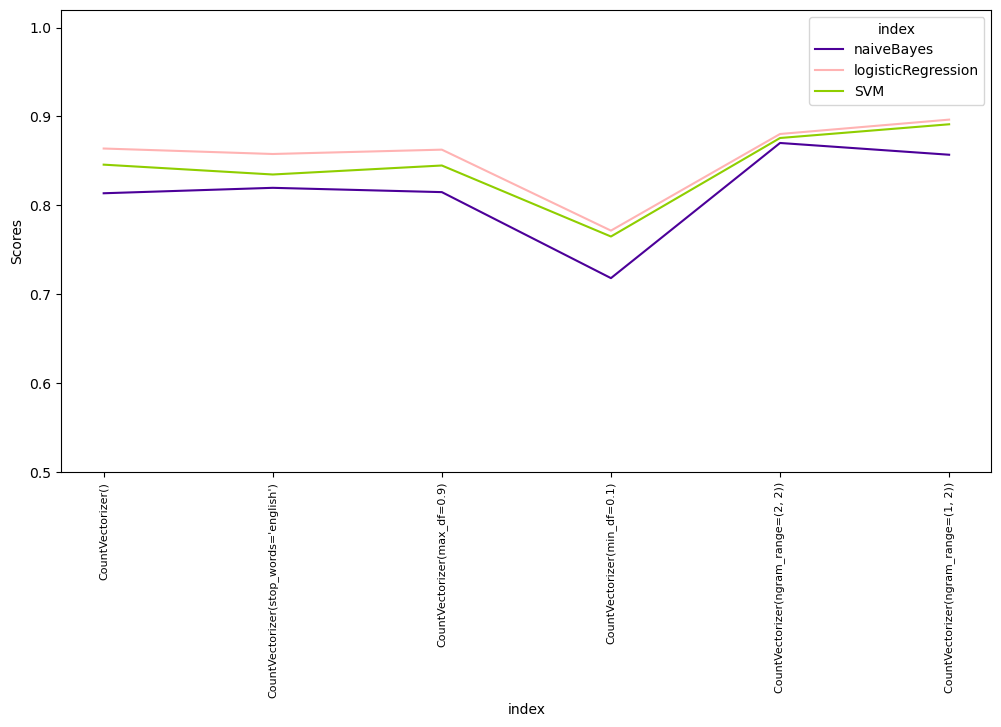

In [9]:
name_scores = ['acc_nb', 'acc_lr', 'acc_svm']
colors = ["#4C0099", "#FFB3B3", "#8fce00"]

data = pd.DataFrame(eval_bagOfWords)
data.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
data = data.set_index('index')
data = data.T
data = data.reset_index()
data = data[['naiveBayes', 'logisticRegression', 'SVM']]
labels = [CountVectorizer(),
 CountVectorizer(stop_words='english'),
 CountVectorizer(max_df=0.9),
 CountVectorizer(min_df=0.1),
 CountVectorizer(ngram_range=(2, 2)),
 CountVectorizer(ngram_range=(1, 2))]
fig, ax= plt.subplots(figsize = (12,6))

ax.set_ylim(0.5, 1.02)
ax = sns.lineplot(data = data[['naiveBayes', 'logisticRegression', 'SVM']], palette=colors , dashes=False)
ax.set_xlabel("index")
ax.set_ylabel("Scores")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, multialignment="left", fontsize=8)

As we can see, the most efficient parameter was the tokenizer with one or two words by token. The stopwords didn't bring any improvement to our prediction, but eliminating the frequent words worked better.

Further, we are going to explore other preprocessing techniques that could improve our model as well. We keep some that showed good result in the previous analyses and we add others:

* ```trigram```: token made of three words;
* ```uni to trigram```: token made of one to three words;
* ```bi to trigram```: token made of two to three words

In [10]:
dic_bagOfWords_v2 = {
    "default": [CountVectorizer()],
    "rm frequent": [CountVectorizer(max_df=0.9)],
    "bigram": [CountVectorizer(ngram_range=(2,2))],
    "uni and bigram": [CountVectorizer(ngram_range=(1,2))],
    'trigram': [CountVectorizer(ngram_range=(3,3))],
    'uni to trigram': [CountVectorizer(ngram_range=(1,3))],
    'bi to trigram': [CountVectorizer(ngram_range=(2,3))]
}

In [11]:
eval_bagOfWords_v2 = eval_preprocessing(dic_levels=dic_bagOfWords_v2)

/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for default: 0.81356
Logistic Regression accuracy for default: 0.86392
SVM accuracy for default: 0.84576


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for rm frequent: 0.81484
Logistic Regression accuracy for rm frequent: 0.86264
SVM accuracy for rm frequent: 0.8448


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for bigram: 0.87016
Logistic Regression accuracy for bigram: 0.88028
SVM accuracy for bigram: 0.87576


/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/afonso/miniconda3/envs/ap_prog/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Naïve Bayes accuracy for uni and bigram: 0.85692
Logistic Regression accuracy for uni and bigram: 0.89644
SVM accuracy for uni and bigram: 0.8912


: 

In [ ]:
eval_bow_v2 = pd.DataFrame(eval_bagOfWords_v2)
eval_bow_v2.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_bow_v2 = eval_bow_v2.set_index('index')
eval_bow_v2

In [ ]:
data = pd.DataFrame(eval_bagOfWords_v2)
data.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
data = data.set_index('index')
data = data.T
data = data.reset_index()

In [ ]:
name_scores = ['acc_nb', 'acc_lr', 'acc_svm']
colors = ["#4C0099", "#FFB3B3", "#8fce00"]

data = pd.DataFrame(eval_bagOfWords_v2)
data.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
data = data.set_index('index')
data = data.T
data = data.reset_index()
data = data[['naiveBayes', 'logisticRegression', 'SVM']]
labels = [CountVectorizer(),
 CountVectorizer(max_df=0.9),
 CountVectorizer(ngram_range=(2, 2)),
 CountVectorizer(ngram_range=(1, 2)),
 CountVectorizer(ngram_range=(3, 3)),
 CountVectorizer(ngram_range=(1, 3)),
 CountVectorizer(ngram_range=(2, 3))]
fig, ax= plt.subplots(figsize = (12,6))

ax.set_ylim(0.5, 1.02)
ax = sns.lineplot(data = data[['naiveBayes', 'logisticRegression', 'SVM']], palette=colors , dashes=False)
ax.set_xlabel("index")
ax.set_ylabel("Scores")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, multialignment="left", fontsize=8)

The next analyses are turned to lemmatization and removing special characters or small words (until three lettres).

In [ ]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re


nltk.download('punkt')
nltk.download('wordnet')

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
    
def preprocess(text):
    """
    Transforms text to remove unwanted bits.
    """
    text.replace('[^\w\s]', '') # for ponctuation
    text.replace(r'(\b\w{1,3}\b)', '') # for words with 3 letters or less
    text.replace('\d+', '') # for digits

    return text 

In [ ]:
dic_lem = {'lemma': [CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                lowercase = True)],
     'rm elements': [CountVectorizer(preprocessor=preprocess)]
                                }

In [ ]:
eval_lemma = eval_preprocessing(dic_levels=dic_lem)

In [ ]:
eval_lemma = pd.DataFrame(eval_lemma)
eval_lemma.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_lemma = eval_lemma.set_index('index')
eval_lemma

For the last step we will assemble the best techniques into the same encoding to see how the models perform with their combination

In [ ]:
dic_bagOfWords_v3 = {
    "default": [CountVectorizer()],
    'assembled': [CountVectorizer(max_df=0.9,
                                  ngram_range=(1,3),
                                  tokenizer=LemmaTokenizer(),
                                  preprocessor=preprocess)]
}

In [ ]:
eval_assemb = eval_preprocessing(dic_levels=dic_bagOfWords_v3)

In [ ]:
eval_assemb_df = pd.DataFrame(eval_assemb)
eval_assemb_df.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_assemb_df = eval_assemb_df.set_index('index')
eval_assemb_df

# TF-IDF

In this step we try the TF-IDF encoder and repeat the same steps we did before in the ```bag of words```.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

dic_tfidf = {
    'default': [TfidfVectorizer()],
    "stopwords": [CountVectorizer(stop_words='english')],
    "rm frequent": [TfidfVectorizer(max_df=0.9)],
    'rm rare': [TfidfVectorizer(min_df=0.1)],
    "bigram": [TfidfVectorizer(ngram_range=(2,2))],
    "uni and bigram": [TfidfVectorizer(ngram_range=(1,2))],
    'trigram': [TfidfVectorizer(ngram_range=(3,3))],
    'uni to trigram': [TfidfVectorizer(ngram_range=(1,3))],
    'bi to trigram': [TfidfVectorizer(ngram_range=(2,3))]
}

In [ ]:
eval_tfidf = eval_preprocessing(dic_levels=dic_tfidf)

In [ ]:
eval_tfidf_df = pd.DataFrame(eval_tfidf)
eval_tfidf_df.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_tfidf_df = eval_tfidf_df.set_index('index')
eval_tfidf_df

In [ ]:
name_scores = ['acc_nb', 'acc_lr', 'acc_svm']
colors = ["#4C0099", "#FFB3B3", "#8fce00"]

data = pd.DataFrame(eval_tfidf)
data.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
data = data.set_index('index')
data = data.T
data = data.reset_index()
data = data[['naiveBayes', 'logisticRegression', 'SVM']]
labels = [TfidfVectorizer(),
 CountVectorizer(stop_words='english'),
 TfidfVectorizer(max_df=0.9),
 TfidfVectorizer(min_df=0.1),
 TfidfVectorizer(ngram_range=(2, 2)),
 TfidfVectorizer(ngram_range=(1, 2)),
 TfidfVectorizer(ngram_range=(3, 3)),
 TfidfVectorizer(ngram_range=(1, 3)),
 TfidfVectorizer(ngram_range=(2, 3))]
fig, ax= plt.subplots(figsize = (12,6))

ax.set_ylim(0.5, 1.02)
ax = sns.lineplot(data = data[['naiveBayes', 'logisticRegression', 'SVM']], palette=colors , dashes=False)
ax.set_xlabel("index")
ax.set_ylabel("Scores")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, multialignment="left", fontsize=8)

In [ ]:
dic_tfidf_v2 = {'default': [TfidfVectorizer()],
                'lemma': [TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                lowercase = True)],
                'rm elements': [TfidfVectorizer(preprocessor=preprocess)]
                                }

In [ ]:
eval_tfidf_v2 = eval_preprocessing(dic_levels=dic_tfidf_v2)

In [ ]:
eval_tfidf_df2 = pd.DataFrame(eval_tfidf_v2)
eval_tfidf_df2.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_tfidf_df2 = eval_tfidf_df2.set_index('index')
eval_tfidf_df2

In [ ]:
dic_assemb_tfidf = {
    "default": [TfidfVectorizer()],
    'assembled': [TfidfVectorizer(max_df=0.9,
                                  ngram_range=(1,3),
                                  tokenizer=LemmaTokenizer(),
                                  preprocessor=preprocess)]
}

In [ ]:
eval_assemb_tfidf = eval_preprocessing(dic_levels=dic_assemb_tfidf)

In [ ]:
eval_tfidf_df3 = pd.DataFrame(eval_assemb_tfidf)
eval_tfidf_df3.loc[:, 'index'] = ["model", 'naiveBayes', 'logisticRegression', 'SVM']
eval_tfidf_df3 = eval_tfidf_df3.set_index('index')
eval_tfidf_df3

# Word2vec - CBOW

In this section we are trying a method of word embedding to see how our model performs. In the word2vec model, all words become a vector and the similarity between words are calculated by the cosinus between both vectors.

In this first step we use the word2vec with the ```continuous bag of word``` structure.

In [ ]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

Here we train the word2vec model, which is going to fit a vector for every word in our dictionary

In [ ]:
# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=0, hs=0, negative=5,        
                                cbow_mean=1, epochs=5)

For the aggregation of vectors in order to train our model, we will try different solutions:
* ``mean()``
* ```sum()```
* ```min()```
* ```max()```

In [ ]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize_mean(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.mean(vec, axis = 0)

    return vec2
    

def vectorize_sum(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.sum(vec, axis = 0)

    return vec2


def vectorize_min(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.min(vec, axis = 0)

    return vec2


def vectorize_max(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.max(vec, axis = 0)

    return vec2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


results = {}
################### mean ################################
classes = [pol for text,pol in train]
X = [vectorize_mean(text) for text,pol in train]
X_test = [vectorize_mean(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results.update({'mean': [acc_lr]})

print("accuracy for mean aggregation: ", acc_lr)

################### sum ################################
classes = [pol for text,pol in train]
X = [vectorize_sum(text) for text,pol in train]
X_test = [vectorize_sum(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results.update({'sum': [acc_lr]})

print("accuracy for sum aggregation: ", acc_lr)

################### minimum ################################
classes = [pol for text,pol in train]
X = [vectorize_min(text) for text,pol in train]
X_test = [vectorize_min(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results.update({'min': [acc_lr]})

print("accuracy for minimum aggregation: ", acc_lr)

################### maximum ################################
classes = [pol for text,pol in train]
X = [vectorize_max(text) for text,pol in train]
X_test = [vectorize_max(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results.update({'max': [acc_lr]})

print("accuracy for maximum aggregation: ", acc_lr)

For the aggregation method, taking the mean of vectors seems to be the best choise when trying to do predictions

In [ ]:
pd.DataFrame(results)

# Wors2vec - Skip Gram

We now try the word2vec with the ```Skip gram``` structure

In [ ]:
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

In [ ]:
# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,               
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        
                                cbow_mean=1, epochs=5)

In [ ]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them


def vectorize_mean(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.mean(vec, axis = 0)

    return vec2
    

def vectorize_sum(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.sum(vec, axis = 0)

    return vec2


def vectorize_min(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.min(vec, axis = 0)

    return vec2


def vectorize_max(text,mean=False):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """    
    vec = []
    text = text.split()
    for word in text:
        if word in w2v.wv.key_to_index:
            vecteur = w2v.wv[word]
            vec.append(vecteur)
        else:
            pass
    
    vec2 = np.max(vec, axis = 0)

    return vec2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

results_sg = {}
################### mean ################################
classes = [pol for text,pol in train]
X = [vectorize_mean(text) for text,pol in train]
X_test = [vectorize_mean(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results_sg.update({'mean': [acc_lr]})

print("accuracy for mean aggregation: ", acc_lr)

################### sum ################################
classes = [pol for text,pol in train]
X = [vectorize_sum(text) for text,pol in train]
X_test = [vectorize_sum(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results_sg.update({'sum': [acc_lr]})

print("accuracy for sum aggregation: ", acc_lr)

################### minimum ################################
classes = [pol for text,pol in train]
X = [vectorize_min(text) for text,pol in train]
X_test = [vectorize_min(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results_sg.update({'min': [acc_lr]})

print("accuracy for minimum aggregation: ", acc_lr)

################### maximum ################################
classes = [pol for text,pol in train]
X = [vectorize_max(text) for text,pol in train]
X_test = [vectorize_max(text) for text,pol in test]
true = [pol for text,pol in test]

clf = LogisticRegression()
clf.fit(X, classes)
y_pred = clf.predict(X_test)
acc_lr = accuracy_score(true, y_pred)

results_sg.update({'max': [acc_lr]})

print("accuracy for maximum aggregation: ", acc_lr)

In [ ]:
pd.DataFrame(results_sg)

# Conclusions

From the tests we performed here, the one that seems to work the best is the ```bag of words encoding```, with some modifications to the intern parameters of the function.

The ```word2vec``` performed better when used with the ```skip gram``` architecture and the mean aggregation.

For better performances of prediction we would consider applying hyperparameters tuning for the models we chose to train or even changing the model.